# CEP290 Cross-Experiment Analysis Tutorial

End-to-end analysis of CEP290 crispant experiments using `src/analyze`.

**Pipeline**: Feature plotting → PCA → DTW clustering → Cross-experiment projection → Classification tests

**Data**: Two CEP290 crispant experiments (20260122, 20260124) from `build06_output` (includes curvature metrics + VAE latents).

**Note**: Bootstrap/permutation counts are reduced for speed (`n_bootstrap=20`, `n_permutations=50`). For production analyses, increase `n_bootstrap` to 100+ and `n_permutations` to 200+.

# Load Data

In [2]:
# Cell 1: Setup & Data Loading
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Project paths — assumes notebook is run from src/analyze/tutorials/
TUTORIAL_DIR = Path.cwd()
project_root = TUTORIAL_DIR.parents[2]  # tutorials → analyze → src → repo root
sys.path.insert(0, str(project_root / "src"))

OUTPUT_DIR = TUTORIAL_DIR / "output"
FIGURES_DIR = OUTPUT_DIR / "figures" / "notebook"
RESULTS_DIR = OUTPUT_DIR / "results"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Load both CEP290 experiments (build06 has curvature + z_mu_b latents)
data_dir = project_root / "morphseq_playground" / "metadata" / "build06_output"
source_dfs = {}
for exp_id in ["20260122", "20260124"]:
    df_exp = pd.read_csv(data_dir / f"df03_final_output_with_latents_{exp_id}.csv", low_memory=False)
    df_exp = df_exp[df_exp["use_embryo_flag"]].copy()
    df_exp["experiment_id"] = exp_id
    source_dfs[exp_id] = df_exp

df = pd.concat(source_dfs.values(), ignore_index=True)

print(f"Loaded {df['embryo_id'].nunique()} embryos, {len(df)} timepoints")
print(f"Experiments: {sorted(df['experiment_id'].unique())}")
print(f"Genotypes: {sorted(df['genotype'].unique())}")
print(f"Time range: {df['predicted_stage_hpf'].min():.1f}\u2013{df['predicted_stage_hpf'].max():.1f} hpf")

# Shared color palette
from analyze.trajectory_analysis.viz.styling import get_color_for_genotype

color_lookup = {gt: get_color_for_genotype(gt) for gt in df["genotype"].unique()}

Loaded 211 embryos, 14686 timepoints
Experiments: ['20260122', '20260124']
Genotypes: ['ab', 'cep290_crispant']
Time range: 11.0–77.4 hpf


# Plotting features over time functions

- `plot_feature_over_time()`: Line plots of feature trajectories across time, colored by genotype.
  - plots both Plotly (interactive) and matplotlib backends.

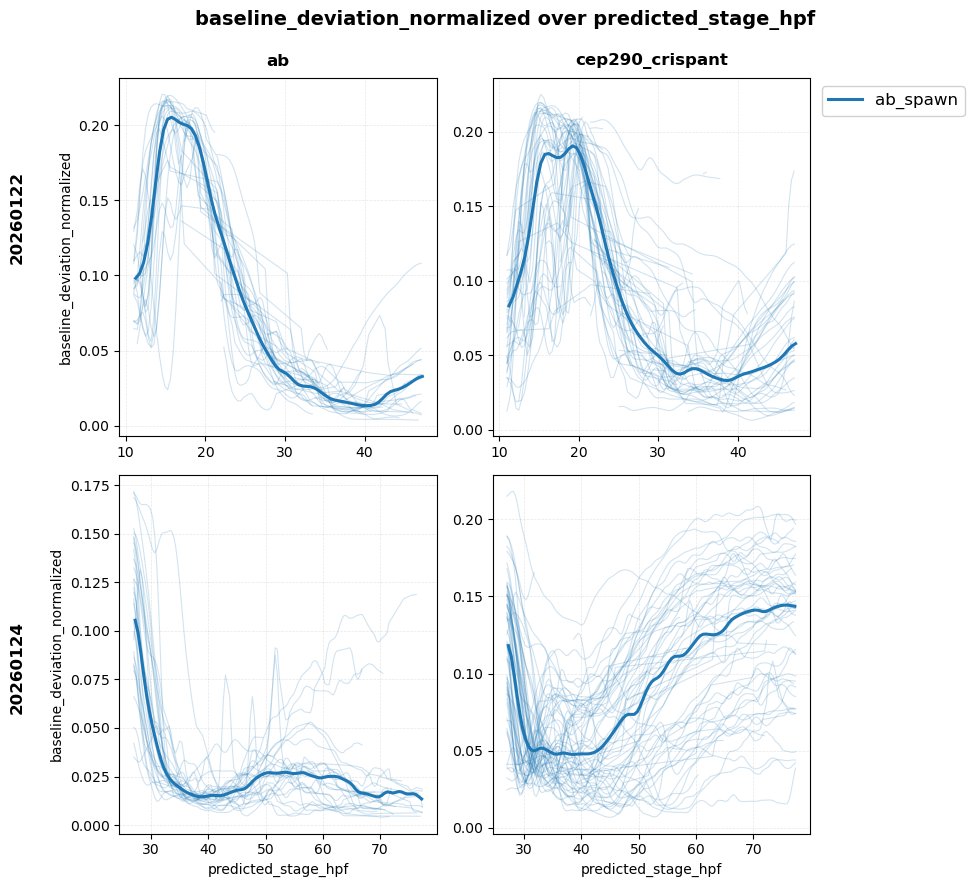

In [ ]:
from analyze.viz.plotting import plot_feature_over_time

# # Example 1: Single feature — curvature by genotype (both backends)
# figs = plot_feature_over_time(
#     df,
#     features="baseline_deviation_normalized",
#     color_by="genotype",
#     color_lookup=color_lookup,
#     backend="both",
# )
# figs["plotly"].write_html(FIGURES_DIR / "notebook_01_curvature.html")
# figs["plotly"].show()
# figs["matplotlib"].savefig(FIGURES_DIR / "notebook_01_curvature.png", dpi=300, bbox_inches="tight")
# plt.show()

# Example 2: Facetted plotting demonstration experiment vs genotype
figs = plot_feature_over_time(
    df,
    features="baseline_deviation_normalized",
    facet_row="experiment_id",
    facet_col="genotype",
    color_by="pair",
    backend="matplotlib",
)
plt.show()


# Example 3: Multi-feature faceted (curvature + length × genotype)
figs = plot_feature_over_time(
    df,
    features=["baseline_deviation_normalized", "total_length_um"],
    color_by="genotype",
    facet_col="genotype",
    backend="matplotlib",
)
plt.savefig(FIGURES_DIR / "notebook_01_multi_feature.png", dpi=300, bbox_inches="tight")
plt.show()

print("Feature-over-time plots saved")



## PCA & 3D Scatter

Reduce VAE latent dimensions with PCA and visualize embryo trajectories in 3D space. `fit_transform_pca()` auto-detects `z_mu_b_*` columns; `plot_3d_scatter()` supports both categorical and continuous coloring.

In [3]:
from analyze.utils import fit_transform_pca
from analyze.viz.plotting import plot_3d_scatter

df_pca, pca, scaler, z_mu_cols = fit_transform_pca(df, n_components=3)
pca_cols = ["PCA_1", "PCA_2", "PCA_3"]

var = pca.explained_variance_ratio_
print(f"PCA variance explained: PC1={var[0]*100:.1f}%, PC2={var[1]*100:.1f}%, PC3={var[2]*100:.1f}% (total={var.sum()*100:.1f}%)")

# 3D scatter colored by genotype
fig = plot_3d_scatter(
    df_pca,
    coords=pca_cols,
    color_by="genotype",
    color_palette=color_lookup,
    show_lines=False,
    show_mean=False,
)
fig.write_html(FIGURES_DIR / "notebook_02_pca_3d.html")
fig.show()

# 3D scatter colored by developmental time
fig_time = plot_3d_scatter(
    df_pca,
    coords=pca_cols,
    color_by="predicted_stage_hpf",
    color_continuous=True,
    colorscale="Viridis",
    colorbar_title="predicted_stage_hpf",
    show_lines=False,
    show_mean=False,
    hover_cols=["genotype", "experiment_id"],
)
fig_time.write_html(FIGURES_DIR / "notebook_02_pca_3d_by_time.html")
fig_time.show()

print("PCA scatter saved")

Auto-detected 80 z_mu_b columns
Fitting PCA on 14686 samples with 80 features
Variance explained by 3 components:
  PC1: 43.0% (cumulative: 43.0%)
  PC2: 27.0% (cumulative: 70.0%)
  PC3: 14.9% (cumulative: 85.0%)
PCA variance explained: PC1=43.0%, PC2=27.0%, PC3=14.9% (total=85.0%)


PCA scatter saved


## DTW Clustering

Cluster embryo trajectories using MD-DTW (multidimensional dynamic time warping) distance and k-medoids. Steps:
1. Check HPF coverage overlap between experiments
2. Compute pairwise trajectory distance matrix
3. Run k-selection with bootstrap stability analysis

Bootstrap count is reduced for speed (`n_bootstrap=20`). For production, use 100+.

In [ ]:
from analyze.trajectory_analysis.utilities.dtw_utils import compute_trajectory_distances
from analyze.trajectory_analysis.clustering import run_k_selection_with_plots
from analyze.viz.hpf_coverage import experiment_hpf_coverage, plot_hpf_overlap_quick

# HPF coverage check
bins_mid, cover_df, cov_count = experiment_hpf_coverage(
    df, experiment_col="experiment_id", hpf_col="predicted_stage_hpf",
    embryo_col="embryo_id", bin_width=0.5, min_embryos_per_bin=3,
)
hpf_start, hpf_end = plot_hpf_overlap_quick(
    bins_mid, cov_count, cover_df=cover_df, min_experiments=2,
    show_heatmap=True,
    coverage_plot_path=FIGURES_DIR / "notebook_03_hpf_coverage.png",
    heatmap_path=FIGURES_DIR / "notebook_03_hpf_heatmap.png",
    show=True,
)
# Override — batch effects in staging can make auto-detection unreliable
hpf_start, hpf_end = 25, 50
time_window = (hpf_start, hpf_end)
print(f"HPF window: {hpf_start}\u2013{hpf_end}")

# Compute MD-DTW distance matrix
FEATURES = ["baseline_deviation_normalized"]
D, embryo_ids, time_grid = compute_trajectory_distances(
    df, metrics=FEATURES, time_col="predicted_stage_hpf",
    time_window=time_window, embryo_id_col="embryo_id",
    normalize=True, sakoe_chiba_radius=20, verbose=True,
)
print(f"Distance matrix: {D.shape}, range [{D.min():.2f}, {D.max():.2f}]")

# K-selection (reduced bootstrap for speed)
df_filtered = df[df["embryo_id"].isin(embryo_ids)].copy()
k_selection_dir = FIGURES_DIR / "notebook_03_k_selection"

k_results = run_k_selection_with_plots(
    df=df_filtered, D=D, embryo_ids=embryo_ids,
    output_dir=k_selection_dir,
    k_range=[2, 3, 4, 5, 6],
    n_bootstrap=20,  # Production: use 100+
    method="kmedoids",
    plotting_metrics=["baseline_deviation_normalized", "total_length_um"],
    x_col="predicted_stage_hpf",
    iqr_multiplier=2, verbose=True,
)
print(f"Best k: {k_results['best_k']}")

# Apply k=3 clusters to full dataframe
cluster_assignments = pd.read_csv(k_selection_dir / "cluster_assignments.csv")
df_clustered = df.merge(
    cluster_assignments[["embryo_id", "clustering_k_3"]],
    on="embryo_id", how="left",
).rename(columns={"clustering_k_3": "cluster"})

clustered_path = RESULTS_DIR / "notebook_df_clustered_k3.csv"
df_clustered.to_csv(clustered_path, index=False)
print("K-selection + clustering saved")

/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/analyze/viz/hpf_coverage.py:51: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



HPF window: 25–50
COMPUTE TRAJECTORY DISTANCES

1. Filtering to time window: [25, 50] predicted_stage_hpf
   Embryos before: 211
   Embryos after: 193
            (no data in time window)

2. Preparing multivariate array
   Metrics: ['baseline_deviation_normalized']
   Normalize: True
Preparing multivariate array for 1 metrics...
  Metrics: ['baseline_deviation_normalized']
  Normalization: True
  Embryos: 193

Interpolating 1 metrics to common grid (step=0.5)
  Interpolated multi-metric shape: (6606, 4)
  Time points: 50 (25.1 - 49.6 hpf)
  Array shape: (193, 50, 1)
  Before normalization:
    baseline_deviation_normalized: mean=0.048, std=0.037
  After normalization:
    baseline_deviation_normalized: mean=-0.000000, std=1.000000
  Multivariate array prepared successfully

   Array shape: (193, 50, 1) (embryos x timepoints x metrics)
   Time grid: [25.1, 49.6] (50 points)

3. Computing MD-DTW distances
   Sakoe-Chiba radius: 20
Computing MD-DTW distance matrix...
  Samples: 193
  Arr

## Cross-Experiment Projection

Project new embryos onto well-characterized reference clusters using bootstrap DTW nearest-neighbor classification. This assigns each embryo a cluster label with confidence scores (max_p, entropy).

Reference clusters come from 7 CEP290 experiments analyzed in `20251229_cep290_phenotype_extraction`.

In [ ]:
from analyze.trajectory_analysis import run_bootstrap_projection_with_plots
from analyze.viz.plotting import plot_proportions

# Load reference cluster definitions (CEP290 mutants, 7 experiments)
CEP290_REF_DIR = (
    project_root / "results" / "mcolon"
    / "20251229_cep290_phenotype_extraction" / "final_data"
)
df_ref_data = pd.read_csv(CEP290_REF_DIR / "embryo_data_with_labels.csv", low_memory=False)
labels_valid = pd.read_csv(CEP290_REF_DIR / "embryo_cluster_labels.csv", low_memory=False)
labels_valid = labels_valid.drop_duplicates(subset="embryo_id")
labels_valid = labels_valid[labels_valid["cluster_categories"].notna()].copy()

df_ref = df_ref_data[df_ref_data["embryo_id"].isin(labels_valid["embryo_id"])].copy()

print(f"Reference: {df_ref['embryo_id'].nunique()} embryos")
print(f"Clusters: {labels_valid['cluster_categories'].value_counts().to_dict()}")

# Project each experiment onto reference (combined approach)
df_combined = pd.concat(source_dfs.values(), ignore_index=True)

PROJECTION_DIR = FIGURES_DIR / "notebook_04_projection"
projection_results = run_bootstrap_projection_with_plots(
    source_df=df_combined,
    reference_df=df_ref,
    labels_df=labels_valid,
    output_dir=PROJECTION_DIR,
    run_name="combined_projection",
    id_col="embryo_id",
    time_col="predicted_stage_hpf",
    cluster_col="cluster_categories",
    category_col=None,
    metrics=["baseline_deviation_normalized"],
    sakoe_chiba_radius=20,
    n_bootstrap=20,  # Production: use 100+
    frac=0.8,
    bootstrap_on="reference",
    method="nearest_neighbor",
    classification="2d",
    normalize=True,
    verbose=True,
    save_outputs=True,
)

df_proj = projection_results["assignments_df"]
genotype_map = dict(zip(df_combined["embryo_id"], df_combined["genotype"]))
experiment_map = dict(zip(df_combined["embryo_id"], df_combined["experiment_id"]))
df_proj["genotype"] = df_proj["embryo_id"].map(genotype_map)
df_proj["experiment_id"] = df_proj["embryo_id"].map(experiment_map)

# Save projection results
df_proj.to_csv(PROJECTION_DIR / "combined_projection_bootstrap.csv", index=False)

# Proportion summary
print("\nCluster proportions by genotype:")
prop = df_proj.groupby("genotype")["cluster_label"].value_counts(normalize=True).unstack(fill_value=0)
print((prop * 100).round(1))

# Proportion plot by experiment and genotype
df_embryo_proj = df_proj.drop_duplicates(subset="embryo_id")
fig = plot_proportions(
    df_embryo_proj,
    color_by_grouping="cluster_label",
    row_by="genotype",
    col_by="experiment_id",
    count_by="embryo_id",
    normalize=True,
    bar_mode="grouped",
    title="Cluster Distribution by Experiment and Genotype",
    show_counts=True,
)
plt.savefig(FIGURES_DIR / "notebook_04_proportion_by_experiment.png", dpi=150, bbox_inches="tight")
plt.show()

print("Cross-experiment projection saved")

Reference: 571 embryos
Clusters: {'Not Penetrant': 289, 'High_to_Low': 141, 'Low_to_High': 101, 'Intermediate': 40}
BOOTSTRAP PROJECTION WITH PLOTS
Run name: combined_projection
ID column: embryo_id
Time column: predicted_stage_hpf
Cluster column: cluster_categories
Category column: cluster_categories
Metrics: ['baseline_deviation_normalized']
Bootstrap: n=20, frac=0.8
Method: nearest_neighbor
PREPARE PROJECTION ARRAYS

Source embryos: 211
Reference embryos: 571
Metrics: ['baseline_deviation_normalized']

Projection time window: 12.0 - 77.4 hpf
  (intersection of source and reference coverage)

Filtered datasets:
  Source: 211 embryos
  Reference: 571 embryos

Preparing reference array...
  Shape: (571, 131, 1)
  Time grid: 131 points (12.0 - 77.0 hpf)

Preparing source array...


## Classification Tests

Run permutation-based classification tests to quantify phenotypic differences between clusters:
- **Mode 1: One-vs-Rest** — How distinguishable is each cluster from all others?
- **Mode 2: vs Not Penetrant** — How different is each mutant cluster from wild-type-like embryos?
- **Mode 3: Crispant vs Homozygous (negative control)** — Within the same phenotypic cluster, crispants and homozygous mutants should be indistinguishable (AUROC ~0.5).
- **Mode 4: ab vs Wildtype (negative control)** — Two wildtype strains from different genetic backgrounds should also be indistinguishable (AUROC ~0.5).

Three feature sets are compared: curvature, body length, and VAE embedding.

Permutation count is reduced for speed (`n_permutations=50`). For production, use 200+.

**Caveat**: Modes 3/4 combine data across experiments. VAE batch effects inflate embedding AUROCs (~0.8) even for expected-null comparisons. Curvature-only controls are more reliable.

In [ ]:
from analyze.difference_detection import run_classification_test
from analyze.difference_detection.classification_test_viz import (
    plot_feature_comparison_grid,
    plot_multiple_aurocs,
)

# Load projection labels — use build06 data (has z_mu_b latents)
proj_labels = df_proj[["embryo_id", "cluster_label", "membership"]].drop_duplicates(subset="embryo_id")
df_target = df.merge(proj_labels, on="embryo_id", how="inner")
df_target = df_target[df_target["cluster_label"].notna()].copy()

print(f"Classification data: {df_target['embryo_id'].nunique()} embryos")
print(f"Clusters: {df_target.groupby('cluster_label')['embryo_id'].nunique().to_dict()}")

FEATURE_SETS = {
    "curvature": ["baseline_deviation_normalized"],
    "length": ["total_length_um"],
    "embedding": "z_mu_b",
}
FEATURE_LABELS = {
    "curvature": "Curvature",
    "length": "Body Length",
    "embedding": "VAE Embedding",
}
CLUSTER_COLORS = {
    "Not Penetrant": "#4477AA",
    "Low_to_High": "#EE6677",
    "Intermediate": "#228833",
    "High_to_Low": "#CCBB44",
}

# --- Mode 1: One-vs-Rest ---
print("\nMode 1: One-vs-Rest classification")
ovr_results = {}
for feat_key, features in FEATURE_SETS.items():
    res = run_classification_test(
        df_target, groupby="cluster_label", groups="all", reference="rest",
        features=features, n_permutations=50, n_jobs=4, verbose=False,
    )
    ovr_results[feat_key] = res

fig = plot_feature_comparison_grid(
    results_by_feature=ovr_results, feature_labels=FEATURE_LABELS,
    cluster_colors=CLUSTER_COLORS, title="One-vs-Rest Classification by Feature Type",
    save_path=FIGURES_DIR / "notebook_05_ovr_comparison.png",
)
plt.show()

# --- Mode 2: Each cluster vs Not Penetrant ---
print("Mode 2: Each cluster vs Not Penetrant")
non_wt = [c for c in df_target["cluster_label"].unique() if c != "Not Penetrant"]
vs_wt_results = {}
for feat_key, features in FEATURE_SETS.items():
    res = run_classification_test(
        df_target, groupby="cluster_label", groups=non_wt,
        reference="Not Penetrant", features=features,
        n_permutations=50, n_jobs=4, verbose=False,
    )
    vs_wt_results[feat_key] = res

fig = plot_feature_comparison_grid(
    results_by_feature=vs_wt_results, feature_labels=FEATURE_LABELS,
    cluster_colors=CLUSTER_COLORS, title="Cluster vs Not Penetrant by Feature Type",
    save_path=FIGURES_DIR / "notebook_05_vs_wt_comparison.png",
)
plt.show()

print("Modes 1 & 2 done")

### Cross-Experiment Control Comparisons (Modes 3 & 4)

These controls combine data from different experiments to test whether the classification framework correctly returns null results when groups **should** be indistinguishable:

- **Mode 3 (negative control)**: Crispant vs homozygous mutant embryos that both fall in the Low_to_High cluster. If clustering captures genotype-independent morphology, AUROC should be ~0.5.
- **Mode 4 (negative control)**: ab wildtype controls vs cep290_wildtype from the reference dataset. Two wildtype strains should be indistinguishable.

**Important**: Because these comparisons span experiments, VAE embedding features are confounded by batch effects (expect inflated AUROCs ~0.8 for embedding even in null comparisons). Curvature and length are batch-robust and provide the true control signal.

In [ ]:
# --- Mode 3: Negative control — crispant vs homozygous within Low_to_High ---
print("Mode 3: Crispant vs Homozygous Mutant (Low_to_High) — Negative Control")

# Load reference data (homozygous mutants with cluster labels)
REFERENCE_CSV = CEP290_REF_DIR / "embryo_data_with_labels.csv"
df_ref_full = pd.read_csv(REFERENCE_CSV, low_memory=False)
df_ref_full = df_ref_full[df_ref_full["use_embryo_flag"]].copy()

# Filter to homozygous Low_to_High
df_ref_lth = df_ref_full[
    (df_ref_full["genotype"] == "cep290_homozygous")
    & (df_ref_full["cluster_categories"] == "Low_to_High")
].copy()

# Filter target to crispant Low_to_High
df_target_lth = df_target[
    (df_target["genotype"] == "cep290_crispant")
    & (df_target["cluster_label"] == "Low_to_High")
].copy()

print(f"  Reference homozygous L2H: {df_ref_lth['embryo_id'].nunique()} embryos")
print(f"  Target crispant L2H: {df_target_lth['embryo_id'].nunique()} embryos")

# Combine — assign a common column for comparison
df_ref_lth = df_ref_lth.assign(comparison_group="cep290_homozygous")
df_target_lth = df_target_lth.assign(comparison_group="cep290_crispant")

shared_cols = sorted(set(df_ref_lth.columns) & set(df_target_lth.columns))
df_neg_ctrl = pd.concat(
    [df_ref_lth[shared_cols], df_target_lth[shared_cols]], ignore_index=True
)

neg_ctrl_results = {}
for feat_key, features in FEATURE_SETS.items():
    res = run_classification_test(
        df_neg_ctrl,
        groupby="comparison_group",
        groups="cep290_crispant",
        reference="cep290_homozygous",
        features=features,
        n_permutations=50,  # Production: use 200+
        n_jobs=4,
        verbose=False,
    )
    neg_ctrl_results[feat_key] = res

# --- Mode 4: Negative control — ab vs cep290_wildtype ---
print("\nMode 4: ab vs cep290_wildtype — Negative Control")

df_ref_wt = df_ref_full[df_ref_full["genotype"] == "cep290_wildtype"].copy()
df_target_ab = df_target[df_target["genotype"] == "ab"].copy()

df_ref_wt = df_ref_wt.assign(comparison_group="cep290_wildtype")
df_target_ab = df_target_ab.assign(comparison_group="ab")

print(f"  Reference wildtype: {df_ref_wt['embryo_id'].nunique()} embryos")
print(f"  Target ab: {df_target_ab['embryo_id'].nunique()} embryos")

shared_cols_pc = sorted(set(df_ref_wt.columns) & set(df_target_ab.columns))
df_pos_ctrl = pd.concat(
    [df_ref_wt[shared_cols_pc], df_target_ab[shared_cols_pc]], ignore_index=True
)

pos_ctrl_results = {}
for feat_key, features in FEATURE_SETS.items():
    res = run_classification_test(
        df_pos_ctrl,
        groupby="comparison_group",
        groups="ab",
        reference="cep290_wildtype",
        features=features,
        n_permutations=50,  # Production: use 200+
        n_jobs=4,
        verbose=False,
    )
    pos_ctrl_results[feat_key] = res

# Plot control comparisons side by side using plot_multiple_aurocs
CTRL_COLORS = {
    "Crispant vs Homozygous (L2H)": "#EE6677",
    "ab vs Wildtype (all)": "#4477AA",
}

fig, axes = plt.subplots(1, len(FEATURE_SETS), figsize=(6 * len(FEATURE_SETS), 5))
for idx, feat_key in enumerate(FEATURE_SETS):
    ax = axes[idx]

    dfs_dict = {}
    # Negative control
    neg_res = neg_ctrl_results[feat_key]
    for (pos, neg), sub_df in neg_res.items():
        dfs_dict["Crispant vs Homozygous (L2H)"] = sub_df

    # Positive control
    pos_res = pos_ctrl_results[feat_key]
    for (pos, neg), sub_df in pos_res.items():
        dfs_dict["ab vs Wildtype (all)"] = sub_df

    plot_multiple_aurocs(
        auroc_dfs_dict=dfs_dict,
        colors_dict=CTRL_COLORS,
        title=FEATURE_LABELS[feat_key],
        ax=ax,
        ylim=(0.3, 1.05),
    )

fig.suptitle(
    "Control Comparisons (expect AUROC \u2248 0.5)",
    fontsize=16, fontweight="bold", y=1.02,
)
fig.tight_layout()
fig.savefig(FIGURES_DIR / "notebook_05_control_comparisons.png", dpi=300, bbox_inches="tight")
plt.show()

print("Modes 3 & 4 done")

### Classification Summary

Combined summary table across all four modes and three feature types.

In [ ]:
# Combined summary table across all 4 modes
summary_rows = []
for mode, results_dict, mode_label in [
    ("ovr", ovr_results, "One-vs-Rest"),
    ("vs_wt", vs_wt_results, "vs Not Penetrant"),
    ("neg_ctrl", neg_ctrl_results, "Crispant vs Homozygous (L2H)"),
    ("pos_ctrl", pos_ctrl_results, "ab vs Wildtype"),
]:
    for feat_key, res in results_dict.items():
        s = res.summary()
        for _, row in s.iterrows():
            summary_rows.append({
                "mode": mode_label,
                "feature": FEATURE_LABELS.get(feat_key, feat_key),
                "positive": row["positive"],
                "negative": row["negative"],
                "max_auroc": row.get("max_auroc", np.nan),
                "min_pval": row.get("min_pval", np.nan),
            })

summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv(RESULTS_DIR / "notebook_classification_summary.csv", index=False)
print("Classification summary saved")
summary_df

## Key Takeaways

1. **Phenotype emergence**: CEP290 crispant penetrance becomes detectable ~26-30 hpf, consistent with homozygous mutant timing.
2. **Embedding vs single metrics**: VAE embedding (z_mu_b) outperforms curvature or length alone for early phenotype detection (higher AUROC).
3. **Cross-experiment controls**: Embedding-based controls (Modes 3/4) show inflated AUROCs (~0.8) even for expected-null comparisons due to VAE batch effects across experiments. Curvature and length controls correctly return ~0.5, confirming they are batch-robust.
4. **Projection**: Bootstrap projection onto well-characterized reference clusters provides per-embryo confidence scores (max_p, entropy).
5. **Practical implication**: For cross-experiment comparisons, prefer curvature-based metrics over embedding features. Use embedding features only within a single experiment or after batch correction.